In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install requests_cache
!pip install pandas_ta

     |████████████████████████████████| 44 kB 1.3 MB/s 
     |████████████████████████████████| 138 kB 11.6 MB/s 
     |████████████████████████████████| 127 kB 43.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 115 kB 5.2 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=bc515026b8fd0681330cb53daf908b863fc9b3b2f7f7d9f0b99d4864034d1f1d
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [ ]:
import tensorflow
from pandas_datareader.data import DataReader
import requests_cache
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import pandas_ta as pta

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_adj_close(ticker, start_date, end_date):
      # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
    try:
      s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
      s = s.loc[:,['Close', 'Open', 'Volume']]#s.loc[:,['Adj Close', 'Open', 'Volume']]
    except:
      print(ticker)
      s = pd.DataFrame(columns = ['Close', 'Open', 'Volume'])
    return s

In [ ]:
def read_clean(file_name, flag = False):
  if flag:
    data = pd.read_csv(f'/content/drive/MyDrive/BT4222/{file_name}.csv').loc[:,['Date', 'Text', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Apple']]
  else:
    data = pd.read_csv(f'/content/drive/MyDrive/BT4222/{file_name}.csv').loc[:,['Date', 'Text', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',]]
  data = data.iloc[::-1]
  if flag:
    data['Apple'] = data['Apple'].fillna(0)
  data = data.dropna()
  data['Text'] = data['Text'].astype(str)
  data = data.reset_index(drop = True)
  data['Date'] = data['Date'].apply(lambda x: x[:10])
  return data

In [ ]:
df_aapl = read_clean('Apple Final', True)
df_aapl.head(3).append(df_aapl.tail(3))

,Date,Text,0,1,2,3,4,5,6,7,8,9,Apple
0,2016-04-27,"New York, April 27, 2016 -- Moody's Investors ...",0.237778,0.122849,0.000000,0.000000,0.102505,0.180161,0.000000,0.355148,0.000000,0.000000,0.0
1,2017-09-25,Shutterstock/Christopher BoswellBrands are dea...,0.014851,0.000000,0.058540,0.064318,0.046805,0.000000,0.261102,0.090984,0.127309,0.330061,0.0
2,2017-09-25,YouTube/MKBHDTwo new iPhones went on sale this...,0.013574,0.000000,0.256770,0.027106,0.059296,0.000000,0.086245,0.258422,0.057624,0.240817,0.0
46283,2021-11-10,German chipmaker and Apple-supplier Infineon i...,0.000000,0.251074,0.211776,0.000000,0.210056,0.000000,0.092855,0.230693,0.000000,0.000000,0.0
46284,2021-11-10,Apple will be forced to allow app developers t...,0.000000,0.000000,0.229907,0.000000,0.000000,0.000000,0.662328,0.000000,0.102421,0.000000,0.0
46285,2021-11-10,Apple announced Wednesday it's launching a bus...,0.000000,0.000000,0.115491,0.000000,0.082169,0.000000,0.527206,0.085036,0.000000,0.186787,0.0


In [ ]:
df_fb = read_clean('Facebook Final')
df_fb.head(3).append(df_fb.tail(3))

,Date,Text,0,1,2,3,4,5,6,7,8,9
0,2016-12-16,FacebookFacebook's internet-beaming Aquila was...,0.000000,0.085898,0.070885,0.202683,0.000000,0.302913,0.195776,0.042846,0.066091,0.032630
1,2016-12-20,The artificially intelligent virtual assistant...,0.000000,0.088325,0.000000,0.491659,0.294369,0.055034,0.038034,0.000000,0.000000,0.031673
2,2016-12-20,"There are really two Facebooks: One, the soci...",0.159834,0.025172,0.046716,0.323634,0.063504,0.151010,0.054857,0.034475,0.134124,0.000000
26064,2021-11-04,"LISBON, Portugal — Facebook is wrong to shut d...",0.251355,0.081101,0.073915,0.000000,0.000000,0.162468,0.231127,0.000000,0.197385,0.000000
26065,2021-11-05,"Meta, formerly known as Facebook, is discussin...",0.134059,0.000000,0.000000,0.000000,0.000000,0.000000,0.523716,0.338560,0.000000,0.000000
26066,2021-11-04,As Mark Zuckerberg pursues a future in the met...,0.000000,0.000000,0.000000,0.402432,0.000000,0.000000,0.291879,0.000000,0.298739,0.000000


In [ ]:
df_pg = read_clean('P&G Final')
df_pg.head(3).append(df_pg.tail(3))

,Date,Text,0,1,2,3,4,5,6,7,8,9
0,2016-12-21,Robots are going to take a seat at the confere...,0.000000,0.000000,0.000000,0.242462,0.000000,0.0,0.429128,0.0,0.140387,0.185426
1,2017-04-04,"In the United States, women are paid about 20%...",0.163168,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.831534
2,2017-06-22,The American workplace has been under scrutiny...,0.582914,0.000000,0.000000,0.000000,0.407210,0.0,0.000000,0.0,0.000000,0.000000
4791,2021-10-29,"InvestorPlace - Stock Market News, Stock Advic...",0.067616,0.260097,0.256372,0.164168,0.036605,0.0,0.107325,0.0,0.015966,0.091818
4792,2021-11-02,"InvestorPlace - Stock Market News, Stock Advic...",0.024020,0.077052,0.097718,0.628894,0.014538,0.0,0.080142,0.0,0.013958,0.063638
4793,2021-11-04,"InvestorPlace - Stock Market News, Stock Advic...",0.035151,0.060993,0.316326,0.459481,0.011599,0.0,0.078485,0.0,0.000000,0.037911


In [ ]:
nltk.download('vader_lexicon')
def get_sentiment(df):
  vader = SentimentIntensityAnalyzer()
  scores = df['Text'].apply(vader.polarity_scores).tolist()
  df_score = df.join(pd.DataFrame(scores))
  df_score = df_score.groupby('Date').mean()
  return df_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df_appl_sent, df_fb_sent, df_pg_sent = get_sentiment(df_aapl), get_sentiment(df_fb), get_sentiment(df_pg)

In [ ]:
start_date = '2010-01-01'
df_price_aapl = get_adj_close('AAPL', start_date, df_appl_sent.index[-1])
df_price_aapl.columns = ['close', 'open', 'volume']
df_price_fb = get_adj_close('FB', start_date, df_fb_sent.index[-1])
df_price_fb.columns = ['close', 'open', 'volume']
df_price_pg = get_adj_close('PG', start_date, df_pg_sent.index[-1])
df_price_pg.columns = ['close', 'open', 'volume']
df_price_ir = get_adj_close('^TNX', start_date, '2021-11-12')
df_price_ir.columns = ['close', 'open', 'volume']

In [ ]:
def process_price(df, df_ir):
  df['movement'] = np.where(df['close'] > df['close'].shift(1), 1, 0)
  df['movement'] = df['movement'].shift(-1)
  #Interest Rate
  df['ir'] = df_ir['open']
  #SMA
  df['SMA20'] = df['close'].rolling(window = 20).mean()
  df['SMA50'] = df['close'].rolling(window = 50).mean()
  df['SMA100'] = df['close'].rolling(window = 100).mean()
  #EMA
  df['EMA10'] = df['close'].ewm(span = 10, adjust = False).mean()
  df['EMA20'] = df['close'].ewm(span = 20, adjust = False).mean()
  df['EMA40'] = df['close'].ewm(span = 40, adjust = False).mean()
  #MACD
  exp1 = df['close'].ewm(span = 12, adjust = False).mean()
  exp2 = df['close'].ewm(span = 26, adjust = False).mean()
  df['MACD'] = exp1-exp2
  df['MACD'] = df['MACD']
  df['signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()
  #RSI 
  df['RSI'] = pta.rsi(df['close'], length = 14)
  return df

In [ ]:
df_appl_combine = df_appl_sent.join(process_price(df_price_aapl, df_price_ir))
df_fb_combine = df_fb_sent.join(process_price(df_price_fb, df_price_ir))
df_pg_combine = df_pg_sent.join(process_price(df_price_pg, df_price_ir))

In [ ]:
df_appl_combine.head(3).append(df_appl_combine.tail(3))

,0,1,2,3,4,5,6,7,8,9,Apple,neg,neu,pos,compound,close,open,volume,movement,ir,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-12-13,0.336873,0.026691,0.204749,0.000000,0.000000,0.000000,0.036345,0.148272,0.033436,0.211072,0.0,0.041500,0.845500,0.113000,0.488400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-14,0.000000,0.000000,0.206217,0.000000,0.038028,0.000000,0.196872,0.205386,0.185272,0.163799,0.0,0.017000,0.954500,0.028500,0.134750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-15,0.000000,0.000000,0.000000,0.000000,0.240158,0.000000,0.000000,0.351839,0.401073,0.000000,0.0,0.085000,0.869000,0.047000,-0.202300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-09,0.047202,0.073618,0.197719,0.087104,0.108387,0.037950,0.142383,0.025221,0.143197,0.133103,0.0,0.023444,0.917833,0.058722,0.307561,150.809998,150.199997,56787900.0,0.0,1.464,148.769501,147.5412,146.0764,150.232387,149.021076,147.790724,1.437542,1.268370,57.884203
2021-11-10,0.066309,0.055858,0.235152,0.067905,0.071712,0.006124,0.219917,0.050017,0.069173,0.154434,0.0,0.046200,0.906533,0.047200,0.127720,147.919998,150.020004,65187100.0,0.0,1.473,149.120001,147.4630,146.2326,149.811952,148.916212,147.797030,1.167482,1.248193,48.459639
2021-11-12,0.000000,0.000000,0.417097,0.000000,0.000000,0.054758,0.160047,0.270671,0.000000,0.090039,0.0,0.000000,0.889500,0.110500,0.639600,149.990005,148.429993,63632600.0,NaN,1.572,149.583002,147.2970,146.5344,149.555440,148.928328,147.907390,0.917704,1.132561,54.584914


In [ ]:
from sklearn.preprocessing import StandardScaler
def get_train_test(df, exclude_col):
  # train = df['2016-10-01':'2020-09-30']
  # test = df['2020-10-01':'2021-09-30']
  train = df['2016-01-01':'2020-02-28']
  test = df['2020-03-01':'2021-07-30']
  train = train.dropna() #Weekends
  test = test.dropna() #Weekends
  train_temp = train[exclude_col]
  test_temp = test[exclude_col]
  train = train.drop(exclude_col, axis = 1)
  test = test.drop(exclude_col, axis = 1)
  scaler = StandardScaler()
  scaler.fit(train)
  train = pd.DataFrame(scaler.transform(train), columns = train.columns, index = train.index)
  test = pd.DataFrame(scaler.transform(test), columns = test.columns, index = test.index)
  train[exclude_col] = train_temp
  test[exclude_col] = test_temp
  return train, test

In [ ]:
aapl_train, aapl_test = get_train_test(df_appl_combine, ['movement'])
fb_train, fb_test = get_train_test(df_fb_combine, ['movement'])
pg_train, pg_test = get_train_test(df_pg_combine, ['movement'])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn import metrics
import xgboost as xgb
import keras
import keras.layers as layers
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization
import numpy as np
import nltk
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def logistic_regression_clf(train, test, X, y):
  clf = LogisticRegression().fit(train.loc[:,X], train[y])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test[y]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  plot_confusion_matrix(clf, test.loc[:,X], test[y], cmap = 'Blues')
  plot_roc_curve(clf, test.loc[:,X], test[y])
  return clf, f1, auc

def xgboost_clf(train, test, X, y):
  clf = xgb.XGBClassifier().fit(train.loc[:,X], train[y])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test[y]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  plot_confusion_matrix(clf, test.loc[:,X], test[y], cmap = 'Blues')
  plot_roc_curve(clf, test.loc[:,X], test[y])
  return clf, f1, auc

In [ ]:
def internal_process(df, df_price, X, y):
  def tokenize(txt):
    return ' '.join(word_tokenize(txt))
  df['Text'] = df['Text'].astype(str).apply(tokenize)
  df = df.set_index('Date')
  df = df.join(df_price)
  train, test = get_train_test(df, ['Text', 'movement'])
  train_features = {}
  test_features = {}
  for col in X:
    train_features[col] = tf.constant(train[col].to_list())
    test_features[col] = tf.constant(test[col].to_list())
  raw_train_ds = tf.data.Dataset.from_tensor_slices(
      (train_features, 
      tf.constant(train[y].to_numpy()))
  ).batch(32)
  raw_test_ds = tf.data.Dataset.from_tensor_slices(
      (test_features, 
      tf.constant(test[y].to_numpy()))
  ).batch(32)
  return raw_train_ds, raw_test_ds

def process_CNN_data(df, df_price, X, y):
  df, df_price = df.copy(), df_price.copy()
  raw_train_ds, raw_test_ds = internal_process(df, df_price, X, y)

  max_features = 20000
  embedding_dim = 128
  vectorize_layer = TextVectorization(
      standardize='lower_and_strip_punctuation',
      max_tokens=max_features,
      output_mode="int",
      output_sequence_length=500,
  )

  text_ds = raw_train_ds.map(lambda x, y: x['Text'])
  vectorize_layer.adapt(text_ds)

  def vectorize_text(text, label):
      text = text['Text']
      text = tf.expand_dims(text, -1)
      return vectorize_layer(text), label

  # Vectorize the data.
  train_ds = raw_train_ds.map(vectorize_text)
  test_ds = raw_test_ds.map(vectorize_text)

  # Do async prefetching / buffering of the data for best performance on GPU.
  train_ds = train_ds.cache().prefetch(buffer_size=10)
  test_ds = test_ds.cache().prefetch(buffer_size=10)
  return train_ds, test_ds, max_features, embedding_dim

def build_cnn_model(max_features, embedding_dim):
  model = keras.models.Sequential()
  model.add(layers.Embedding(max_features, embedding_dim))
  model.add(layers.Dropout(0.5))

  model.add(layers.Conv1D(128, 3, padding = "valid", activation = "relu"))
  model.add(layers.MaxPooling1D())
  model.add(layers.Conv1D(512, 3, padding = "valid", activation = "relu"))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation="relu"))
  model.add(layers.Dense(512, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation="sigmoid", name="predictions"))

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC()])
  return model

def cnn_clf(df, df_price, X, y, epochs = 30):
  train_ds, test_ds, max_features, embedding_dim = process_CNN_data(df, df_price, X, y)
  model = build_cnn_model(max_features, embedding_dim)
  model.fit(train_ds, validation_data = test_ds, epochs=epochs)
  logits = np.array(model.predict(test_ds))
  predictions = np.where(logits >= 0.5, 1, 0)
  test_labels = np.array([k[1].numpy() for k in test_ds.unbatch()])

  accuracy = accuracy_score(test_labels, predictions)
  f1 = f1_score(test_labels, predictions)
  auc = roc_auc_score(test_labels, logits)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels, predictions), display_labels=[0,1]).plot(cmap = 'Blues')
  fpr, tpr, thresholds = roc_curve(test_labels, logits)
  RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr),estimator_name='CNN Model').plot()
  plt.show()
  return model, f1, auc

In [ ]:
data_lst = [[aapl_train, aapl_test]]#, [fb_train, fb_test], [pg_train, pg_test]]

SMA

XGB SMA: AAPL
Accuracy: 0.5
F1 score: 0.24680851063829787
AUC score: 0.5105820105820106


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


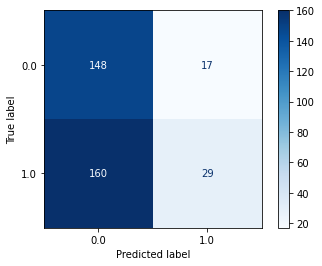

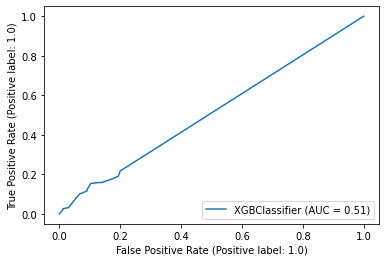

LR SMA: AAPL
Accuracy: 0.5423728813559322
F1 score: 0.676
AUC score: 0.5147025813692481


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


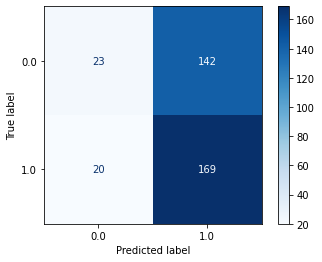

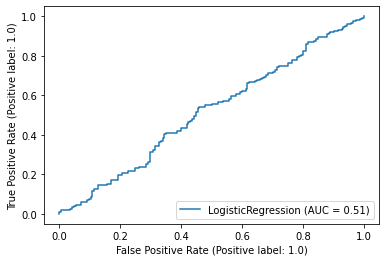

In [ ]:
SMA_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_sma_clfs = {}
lr_sma_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB SMA: {co}')
  xgb_sma, xgb_sma_f1, xgb_sma_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100'], 'movement')
  plt.show()
  print(f'LR SMA: {co}')
  lr_sma, lr_sma_f1, lr_sma_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100'], 'movement')
  plt.show()
  SMA_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_sma_f1, xgb_sma_auc]
  SMA_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_sma_f1, lr_sma_auc]
  xgb_sma_clfs[co] = xgb_sma
  lr_sma_clfs[co] = lr_sma

In [ ]:
SMA_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.246809,0.510582,0.676,0.514703
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


EMA

XGB EMA: AAPL
Accuracy: 0.4717514124293785
F1 score: 0.26666666666666666
AUC score: 0.4950937950937951


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


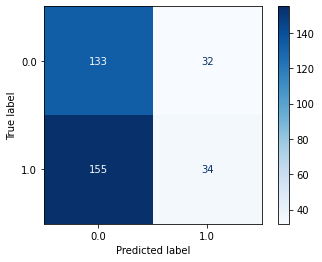

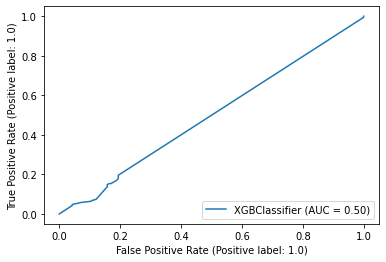

LR EMA: AAPL
Accuracy: 0.5310734463276836
F1 score: 0.6422413793103448
AUC score: 0.5259900593233926


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


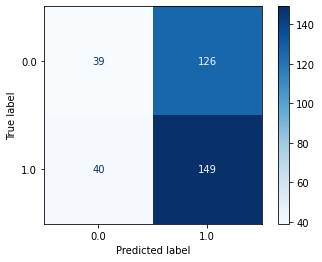

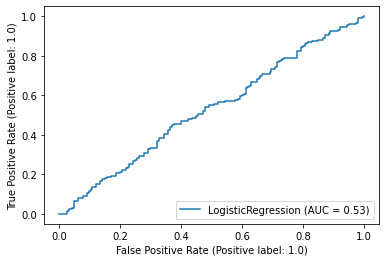

In [ ]:
EMA_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_ema_clfs = {}
lr_ema_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB EMA: {co}')
  xgb_ema, xgb_ema_f1, xgb_ema_auc = xgboost_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40'], 'movement')
  plt.show()
  print(f'LR EMA: {co}')
  lr_ema, lr_ema_f1, lr_ema_auc = logistic_regression_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40'], 'movement')
  plt.show()
  EMA_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_ema_f1, xgb_ema_auc]
  EMA_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_ema_f1, lr_ema_auc]
  xgb_ema_clfs[co] = xgb_ema
  lr_ema_clfs[co] = lr_ema

In [ ]:
EMA_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.266667,0.495094,0.642241,0.52599
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


MACD + RSI + EMA

XGB TA: AAPL
Accuracy: 0.4830508474576271
F1 score: 0.1643835616438356
AUC score: 0.5219336219336219


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


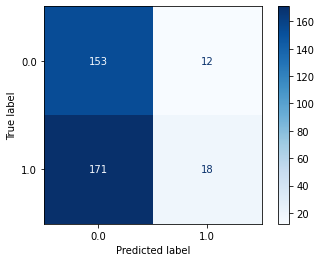

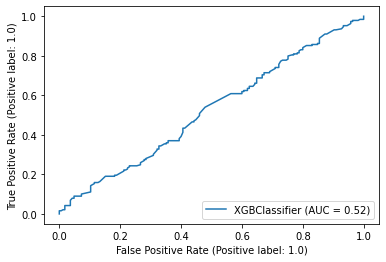

LR TA: AAPL
Accuracy: 0.5338983050847458
F1 score: 0.6080760095011877
AUC score: 0.5186147186147186


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


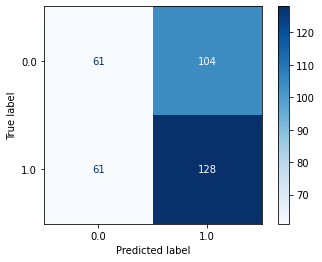

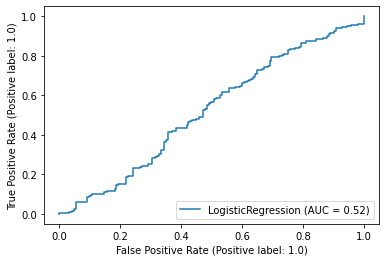

In [ ]:
TAE_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TAE_clfs = {}
lr_TAE_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_ta, xgb_ta_f1, xgb_ta_auc = xgboost_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40', 'MACD', 'signal', 'RSI'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_ta, lr_ta_f1, lr_ta_auc = logistic_regression_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40', 'MACD', 'signal', 'RSI'], 'movement')
  plt.show()
  TAE_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_ta_f1, xgb_ta_auc]
  TAE_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_ta_f1, lr_ta_auc]
  xgb_TAE_clfs[co] = xgb_ta
  lr_TAE_clfs[co] = lr_ta

MACD + RSI + SMA

XGB TA: AAPL
Accuracy: 0.4717514124293785
F1 score: 0.07881773399014778
AUC score: 0.5343755010421677


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


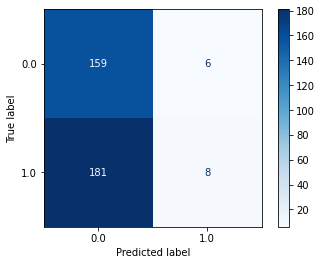

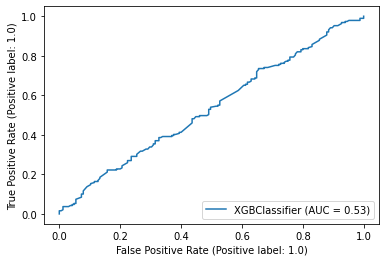

LR TA: AAPL
Accuracy: 0.559322033898305
F1 score: 0.6533333333333333
AUC score: 0.517235850569184


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


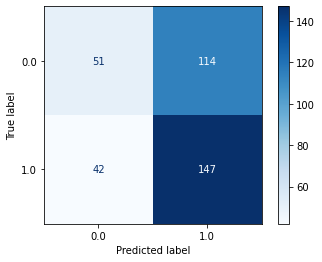

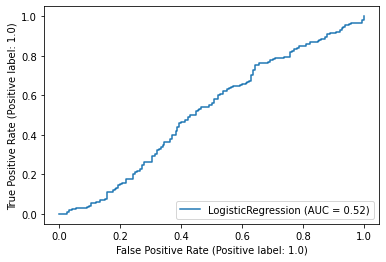

In [ ]:
TA_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TA_clfs = {}
lr_TA_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_ta, xgb_ta_f1, xgb_ta_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_ta, lr_ta_f1, lr_ta_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')
  plt.show()
  TA_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_ta_f1, xgb_ta_auc]
  TA_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_ta_f1, lr_ta_auc]
  xgb_TA_clfs[co] = xgb_ta
  lr_TA_clfs[co] = lr_ta

In [ ]:
TA_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.0788177,0.534376,0.653333,0.517236
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


MACD + RSI + EMA + IR

XGB TA: AAPL
Accuracy: 0.4774011299435028
F1 score: 0.22594142259414227
AUC score: 0.4936988936988937


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


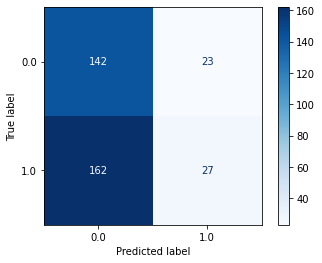

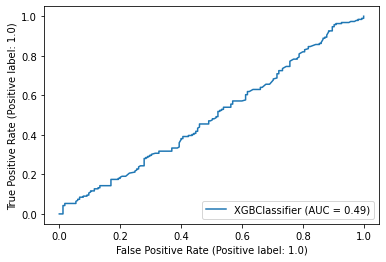

LR TA: AAPL
Accuracy: 0.5423728813559322
F1 score: 0.6493506493506493
AUC score: 0.5098925765592432


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


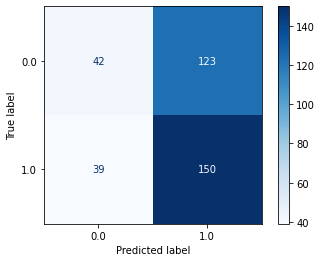

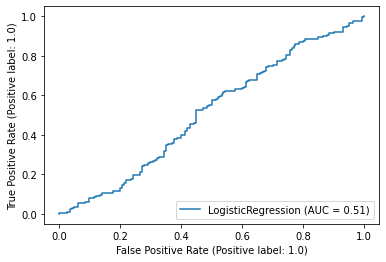

In [ ]:
TAIRE_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TAIRE_clfs = {}
lr_TAIRE_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_tair, xgb_tair_f1, xgb_tair_auc = xgboost_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40', 'MACD', 'signal', 'RSI', 'ir', 'volume'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_tair, lr_tair_f1, lr_tair_auc = logistic_regression_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40', 'MACD', 'signal', 'RSI', 'ir', 'volume'], 'movement')
  plt.show()
  TAIRE_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_tair_f1, xgb_tair_auc]
  TAIRE_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_tair_f1, lr_tair_auc]
  xgb_TAIRE_clfs[co] = xgb_tair
  lr_TAIRE_clfs[co] = lr_tair

MACD + RSI + SMA + IR

XGB TA: AAPL
Accuracy: 0.480225988700565
F1 score: 0.14018691588785046
AUC score: 0.5294853294853294


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


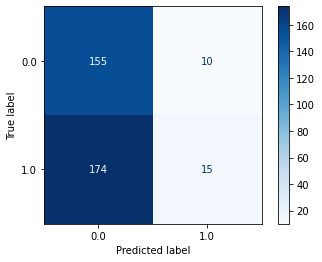

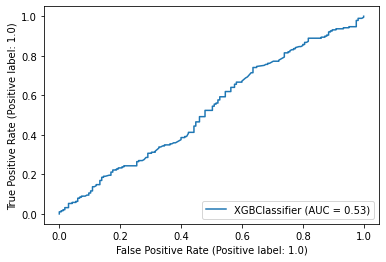

LR TA: AAPL
Accuracy: 0.5451977401129944
F1 score: 0.6596194503171248
AUC score: 0.5151835818502486


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


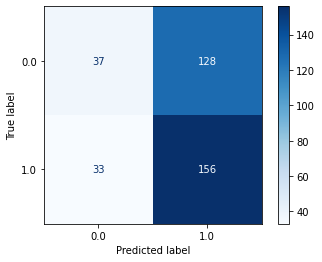

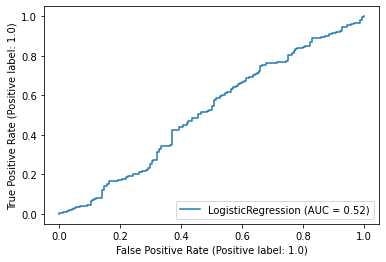

In [ ]:
TAIR_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TAIR_clfs = {}
lr_TAIR_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_tair, xgb_tair_f1, xgb_tair_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'ir', 'volume'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_tair, lr_tair_f1, lr_tair_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'ir', 'volume'], 'movement')
  plt.show()
  TAIR_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_tair_f1, xgb_tair_auc]
  TAIR_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_tair_f1, lr_tair_auc]
  xgb_TAIR_clfs[co] = xgb_tair
  lr_TAIR_clfs[co] = lr_tair

In [ ]:
TAIR_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.140187,0.529485,0.659619,0.515184
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


MACD + RSI + SMA + SENTIMENT

XGB TA: AAPL
Accuracy: 0.4830508474576271
F1 score: 0.18666666666666668
AUC score: 0.5482764149430817


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


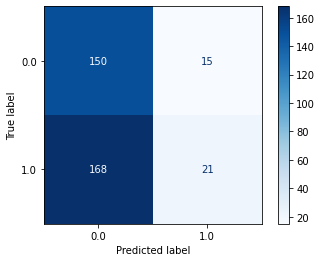

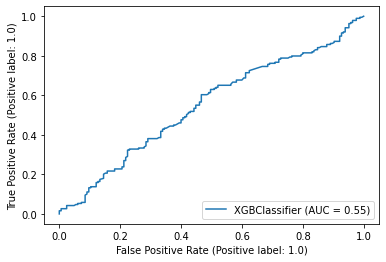

LR TA: AAPL
Accuracy: 0.5480225988700564
F1 score: 0.6491228070175439
AUC score: 0.5232323232323233


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


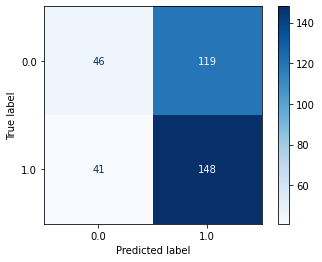

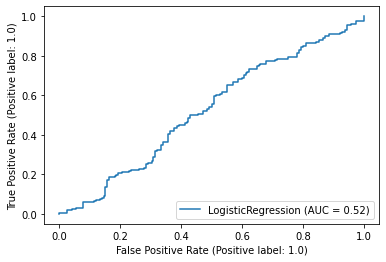

In [ ]:
TAIR_sent_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TAIR_sent_clfs = {}
lr_TAIR_sent_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_tair_sent, xgb_tair_sent_f1, xgb_tair_sent_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_tair_sent, lr_tair_sent_f1, lr_tair_sent_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal','compound'], 'movement')
  plt.show()
  TAIR_sent_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_tair_sent_f1, xgb_tair_sent_auc]
  TAIR_sent_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_tair_sent_f1, lr_tair_sent_auc]
  xgb_TAIR_sent_clfs[co] = xgb_tair_sent
  lr_TAIR_sent_clfs[co] = lr_tair_sent

In [ ]:
TAIR_sent_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.186667,0.548276,0.649123,0.523232
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


In [ ]:
result_df_E = SMA_df.append(EMA_df).append(TAE_df).append(TAIRE_df)
result_df_E = result_df_E.dropna()

In [ ]:
result_df_E['Indicators'] = ['SMA', 'EMA', 'EMA+MACD+RSI', 'EMA+MACD+RSI+IR+VOL']
result_df_E = result_df_E.set_index('Indicators')
result_df_E

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
Indicators,,,,
SMA,0.246809,0.510582,0.676,0.514703
EMA,0.266667,0.495094,0.642241,0.52599
EMA+MACD+RSI,0.164384,0.521934,0.608076,0.518615
EMA+MACD+RSI+IR+VOL,0.225941,0.493699,0.649351,0.509893


In [ ]:
result_df = SMA_df.append(EMA_df).append(TA_df).append(TAIR_df)
result_df = result_df.dropna()

In [ ]:
result_df['Indicators'] = ['SMA', 'EMA', 'SMA+MACD+RSI', 'SMA+MACD+RSI+IR+VOL']
result_df = result_df.set_index('Indicators')
result_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
Indicators,,,,
SMA,0.246809,0.510582,0.676,0.514703
EMA,0.266667,0.495094,0.642241,0.52599
SMA+MACD+RSI,0.0788177,0.534376,0.653333,0.517236
SMA+MACD+RSI+IR+VOL,0.140187,0.529485,0.659619,0.515184


XGB TUNING

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from time import time
from tqdm import tqdm

In [ ]:
def evaluate_auc(xgb_clf, train, test, X):
  clf = xgb_clf.fit(train.loc[:,X], train['movement'])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test['movement']
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  return auc

In [ ]:
def hyperopt(param_space, num_eval, classifier, train, test, X):  
    start = time()
    def objective_function(params):
        clf = classifier(**params)
        score = evaluate_auc(clf,  train, test, X)
        return {'loss': -score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    print(loss)
    return trials, best_param_values

In [ ]:
num_eval = 500

XGB_param_hyperopt = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 550, 20)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 25, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'booster': hp.choice('booster', ['dart','gbtree']), #gblinear
    'gamma': hp.uniform('gamma', 0, 20),
    'min_child_weight': hp.uniform('min_child_weight', 1, 5),
    'subsample': hp.uniform('subsample', 0.1, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.9),
    'reg_lambda': hp.uniform('reg_lambda', 1, 5),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.1),
    'scale_pos_weight':hp.uniform('scale_pos_weight', 1, 10),
    'use_label_encoder':False,
    'random_state': 1
}

In [ ]:
XGB_hyperopt = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'])
XGB_hyperopt_sent = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound'])
XGB_hyperopt_topic = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
XGB_hyperopt_trend = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'Apple'])
XGB_hyperopt_sent_topic_trend = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Apple'])

100%|██████████| 500/500 [03:30<00:00,  2.37it/s, best loss: -0.5704986371653038]
[-0.5168189834856501, -0.4971460638127304, -0.49942279942279943, -0.5, -0.5145903479236813, -0.5162898829565497, -0.5195446528779862, -0.48011864678531346, -0.5292127625460958, -0.5271765271765271, -0.5201699535032868, -0.5111912778579446, -0.5396344396344396, -0.49753086419753084, -0.5373096039762706, -0.5249799583132917, -0.5315856982523649, -0.5124418791085457, -0.5235048901715568, -0.5291165624498958, -0.5130671797338464, -0.5359147025813692, -0.5138688472021805, -0.4978354978354978, -0.5385281385281385, -0.5129389129389129, -0.51996151996152, -0.4914862914862914, -0.5345679012345679, -0.5187910854577522, -0.5253807920474587, -0.5076318742985411, -0.5047939714606382, -0.5299021965688633, -0.5320506653839987, -0.5317780984447651, -0.5221580888247555, -0.538656405323072, -0.5208754208754208, -0.5041526374859708, -0.5465768799102132, -0.5442680776014109, -0.5031425364758698, -0.49642456309122973, -0.5235

In [ ]:
XGB_hyperopt_topic_trend = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Apple'])

100%|██████████| 500/500 [16:00<00:00,  1.92s/it, best loss: -0.6068943402276735]
[-0.5394901394901395, -0.5694404361071028, -0.5404040404040404, -0.5, -0.5388488055154721, -0.517428250761584, -0.5772967772967773, -0.5, -0.5665864999198332, -0.5148949815616481, -0.4307519640852975, -0.5798941798941799, -0.5927529260862594, -0.5256854256854258, -0.5344236010902678, -0.5222061888728555, -0.5469616802950136, -0.5144460477793811, -0.5353856020522687, -0.5338784672118005, -0.5507134840468174, -0.5340067340067339, -0.5378387045053712, -0.5372134038800706, -0.5199294532627866, -0.5449414782748117, -0.553615520282187, -0.5611351611351612, -0.5476671476671476, -0.5262465929132596, -0.5770723104056438, -0.4804232804232804, -0.5548180214846882, -0.5557479557479557, -0.48900112233445564, -0.5651755651755651, -0.51329164662498, -0.5086740420073753, -0.5077441077441077, -0.49453262786596114, -0.5214686548019881, -0.525412858746192, -0.5537598204264871, -0.5225589225589226, -0.5664582331248998, -0.56

In [ ]:
import json
def trials_data(xgb_hyperopt):
    trials = xgb_hyperopt[0].trials
    bayesTrialsData = pd.DataFrame()
    for idx, trial in enumerate(trials):
        loss = trial["result"]["loss"]
        values = list(map(lambda x: x[0], trial["misc"]['vals'].values()))
        label = list(trial["misc"]['vals'].keys())
        index = ['loss']
        index = index + label
        data = [loss]
        data = data + values
        df = pd.DataFrame(data, columns = [idx], index = index).T
        bayesTrialsData = bayesTrialsData.append(df)
    bayesTrialsData = bayesTrialsData.sort_values(by='loss')
    return bayesTrialsData

def xgboost_clf_optim(xgb_clf, train, test, X, y):
  clf = xgb_clf.fit(train.loc[:,X], train[y])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test[y]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  plot_confusion_matrix(clf, test.loc[:,X], test[y], cmap = 'Blues')
  plot_roc_curve(clf, test.loc[:,X], test[y])
  return clf, f1, auc

In [ ]:
XGB_hyperopt_trails = trials_data(XGB_hyperopt)
#XGB_hyperopt_trails

In [ ]:
xg_chosen = XGB_hyperopt[1]
xgb_optimised = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_sent[1]
xgb_optimised_sent = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_topic[1]
xgb_optimised_topic = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_trend[1]
xgb_optimised_trend = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_topic_trend[1]
xgb_optimised_topic_trend = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_sent_topic_trend[1]
xgb_optimised_sent_topic_trend = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])

Accuracy: 0.53954802259887
F1 score: 0.4758842443729904
AUC score: 0.5704986371653038


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


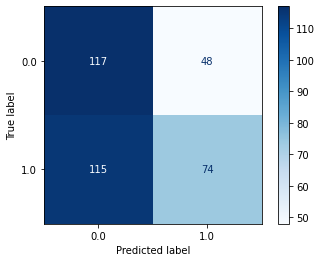

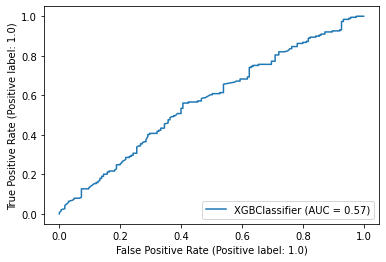

In [ ]:
xgb_best, xgb_f1_best, xgb_auc_best = xgboost_clf_optim(xgb_optimised, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')

Accuracy: 0.576271186440678
F1 score: 0.6052631578947368
AUC score: 0.5842552509219175


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


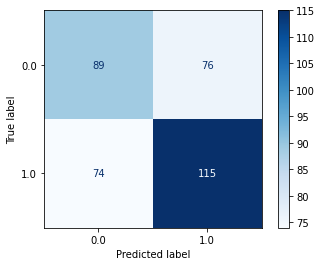

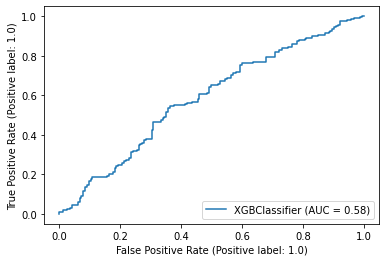

In [ ]:
xgb_best_sent, xgb_f1_best_sent, xgb_auc_best_sent = xgboost_clf_optim(xgb_optimised_sent, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound'], 'movement')

Accuracy: 0.536723163841808
F1 score: 0.6928838951310862
AUC score: 0.6069584736251403


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


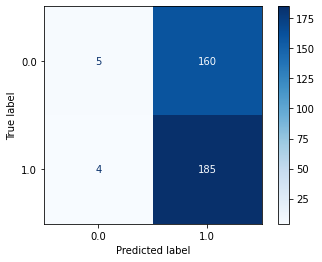

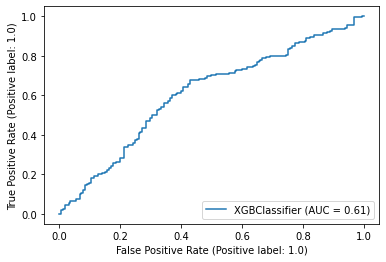

In [ ]:
xgb_best_topic, xgb_f1_best_topic, xgb_auc_best_topic = xgboost_clf_optim(xgb_optimised_topic, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'movement')

Accuracy: 0.5423728813559322
F1 score: 0.5149700598802395
AUC score: 0.5779060445727112


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


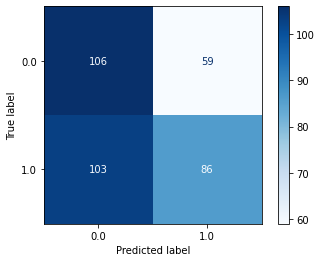

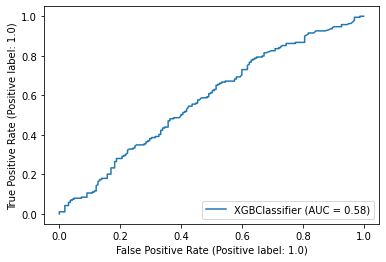

In [ ]:
xgb_best_trend, xgb_f1_best_trend, xgb_auc_best_trend = xgboost_clf_optim(xgb_optimised_trend, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'Apple'], 'movement')

Accuracy: 0.536723163841808
F1 score: 0.6940298507462686
AUC score: 0.6068943402276735


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


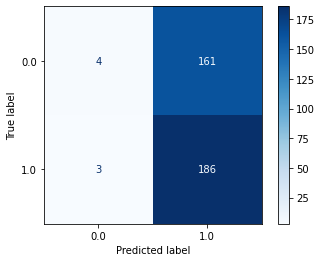

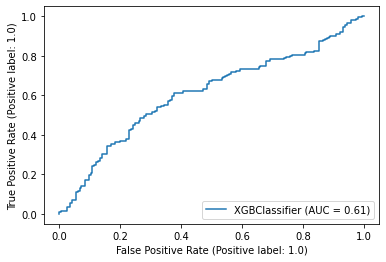

In [ ]:
xgb_best_topic_trend, xgb_f1_best_topic_trend, xgb_auc_best_topic_trend = xgboost_clf_optim(xgb_optimised_topic_trend, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Apple'], 'movement')

Accuracy: 0.5338983050847458
F1 score: 0.696132596685083
AUC score: 0.6027898027898028


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


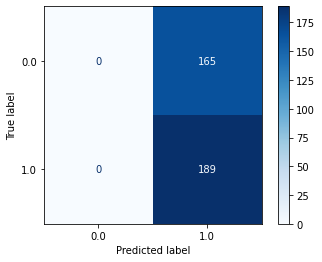

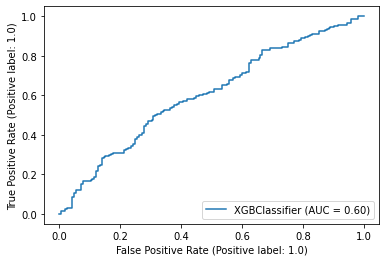

In [ ]:
xgb_best_sent_topic_trend, xgb_f1_best_sent_topic_trend, xgb_auc_best_sent_topic_trend = xgboost_clf_optim(xgb_optimised_sent_topic_trend, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Apple'], 'movement')

In [ ]:
pd.DataFrame([[xgb_f1_best, xgb_auc_best],[xgb_f1_best_sent, xgb_auc_best_sent],[xgb_f1_best_topic, xgb_auc_best_topic], [xgb_f1_best_trend, xgb_auc_best_trend], [xgb_f1_best_topic_trend, xgb_auc_best_topic_trend], [xgb_f1_best_sent_topic_trend, xgb_auc_best_sent_topic_trend]], columns = ['F1', 'AUC'], index = ['Best', '+Sentiment', '+Topic', '+Trend', '+Topic+Trend', '+Sentiment+Topic+Trend'])

,F1,AUC
Best,0.475884,0.570499
+Sentiment,0.605263,0.584255
+Topic,0.692884,0.606958
+Trend,0.514970,0.577906
+Topic+Trend,0.694030,0.606894
+Sentiment+Topic+Trend,0.696133,0.602790


FB

In [ ]:
XGB_hyperopt_fb = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, fb_train, fb_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'])
XGB_hyperopt_sent_fb = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, fb_train, fb_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound'])
XGB_hyperopt_topic_fb = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, fb_train, fb_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

100%|██████████| 500/500 [05:48<00:00,  1.43it/s, best loss: -0.617399648168879]
[-0.5189349112426036, -0.5173836558451943, -0.5153526307372461, -0.5, -0.49891252198944513, -0.5328002558771789, -0.5399968015352631, -0.5372461218615064, -0.5321445706061091, -0.5461058691827922, -0.5193667039820886, -0.5510634895250279, -0.5383335998720615, -0.5148728610267072, -0.5385894770510156, -0.5311850311850311, -0.5170158324004478, -0.5417719494642572, -0.5413241644010875, -0.5340956340956341, -0.5658084119622582, -0.5453222453222454, -0.5452902606748761, -0.5455301455301456, -0.5391172237326084, -0.5520070366224212, -0.5673916520070367, -0.5134015672477211, -0.5554933631856709, -0.5531744762513994, -0.5439469054853671, -0.5420438189668959, -0.5218295218295218, -0.5527426835119142, -0.56702382856229, -0.5034863265632497, -0.5989445066368143, -0.5335678874140413, -0.5297777067007836, -0.5374220374220374, -0.500911562450024, -0.5373260834799296, -0.504733727810651, -0.5184551415320646, -0.557940188

In [ ]:
xg_chosen = XGB_hyperopt_fb[1]
xgb_optimised_fb = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_sent_fb[1]
xgb_optimised_sent_fb = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_topic_fb[1]
xgb_optimised_topic_fb = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])

Accuracy: 0.5225988700564972
F1 score: 0.6852886405959032
AUC score: 0.617399648168879


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


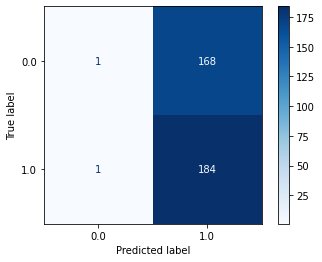

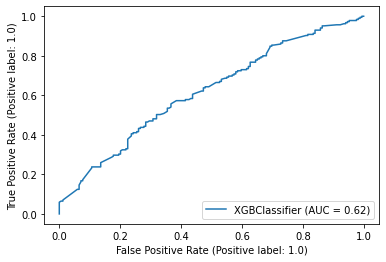

In [ ]:
xgb_best_fb, xgb_f1_best_fb, xgb_auc_best_fb = xgboost_clf_optim(xgb_optimised_fb, fb_train, fb_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')

Accuracy: 0.5254237288135594
F1 score: 0.6731517509727627
AUC score: 0.5883415960339038


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


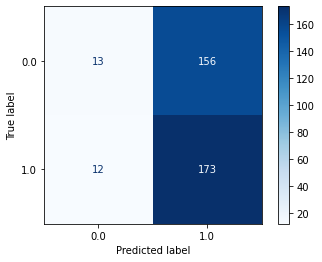

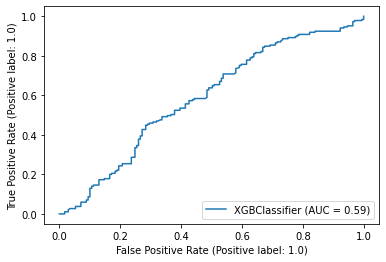

In [ ]:
xgb_best_fb_sent, xgb_f1_best_fb_sent, xgb_auc_best_fb_sent = xgboost_clf_optim(xgb_optimised_sent_fb, fb_train, fb_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound'], 'movement')

Accuracy: 0.559322033898305
F1 score: 0.638888888888889
AUC score: 0.5673116903886135


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


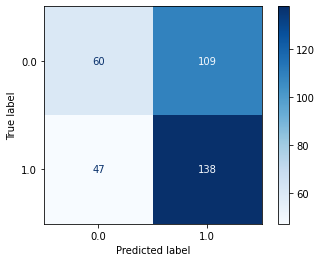

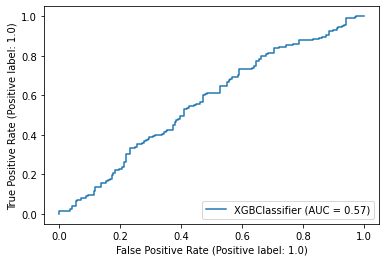

In [ ]:
xgb_best_fb_topic, xgb_f1_best_fb_topic, xgb_auc_best_fb_topic = xgboost_clf_optim(xgb_optimised_topic_fb, fb_train, fb_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI',  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'movement')

In [ ]:
pd.DataFrame([[xgb_f1_best_fb, xgb_auc_best_fb],[xgb_f1_best_fb_sent, xgb_auc_best_fb_sent],[xgb_f1_best_fb_topic, xgb_auc_best_fb_topic]], columns = ['F1', 'AUC'], index = ['Best', '+Sentiment', '+Topic'])

,F1,AUC
Best,0.685289,0.617400
+Sentiment,0.673152,0.588342
+Topic,0.638889,0.567312


P&G

In [ ]:
XGB_hyperopt_pg = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, pg_train, pg_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'])
XGB_hyperopt_sent_pg = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, pg_train, pg_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound'])
XGB_hyperopt_topic_pg = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, pg_train, pg_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

100%|██████████| 500/500 [03:40<00:00,  2.27it/s, best loss: -0.5934009406231628]
[-0.47685185185185186, -0.5140358612580834, -0.5163874191651969, -0.5, -0.5081569664902998, -0.516166960611405, -0.5346854791299236, -0.5092592592592593, -0.5197677836566725, -0.5213844797178131, -0.5055114638447972, -0.47178130511463845, -0.5080834803057025, -0.513888888888889, -0.5269694297472076, -0.5260875955320399, -0.5102880658436214, -0.5184450323339213, -0.5065402704291593, -0.508450911228689, -0.5382128159905938, -0.5040417401528512, -0.5092592592592593, -0.5430629041740154, -0.5421810699588477, -0.5446061140505586, -0.5185185185185185, -0.5495296884185773, -0.527116402116402, -0.5321869488536155, -0.5219723691945914, -0.4656084656084656, -0.5331422692533804, -0.5499706055261612, -0.5299088771310994, -0.5431363903586125, -0.5155055849500294, -0.5047766019988242, -0.4925778953556731, -0.5092592592592593, -0.5341710758377425, -0.5302763080540858, -0.49786890064667844, -0.47802763080540867, -0.48603

In [ ]:
xg_chosen = XGB_hyperopt_pg[1]
xgb_optimised_pg = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_sent_pg[1]
xgb_optimised_sent_pg = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xg_chosen = XGB_hyperopt_topic_pg[1]
xgb_optimised_topic_pg = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])

Accuracy: 0.509090909090909
F1 score: 0.6746987951807228
AUC score: 0.5934009406231628


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


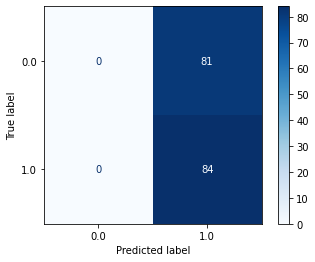

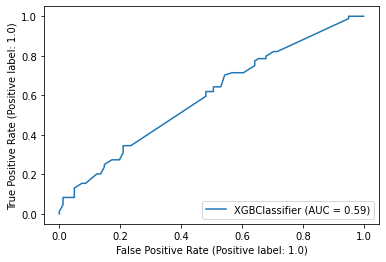

In [ ]:
xgb_best_pg, xgb_f1_best_pg, xgb_auc_best_pg = xgboost_clf_optim(xgb_optimised_pg, pg_train, pg_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')

Accuracy: 0.509090909090909
F1 score: 0.6746987951807228
AUC score: 0.5706937095825985


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


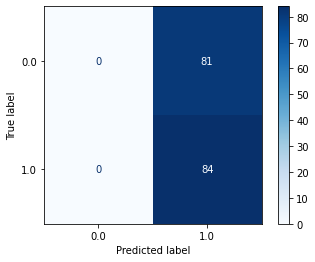

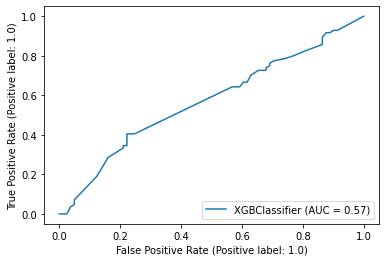

In [ ]:
xgb_best_pg_sent, xgb_f1_best_pg_sent, xgb_auc_best_pg_sent = xgboost_clf_optim(xgb_optimised_sent_pg, pg_train, pg_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'compound'], 'movement')

Accuracy: 0.509090909090909
F1 score: 0.6746987951807228
AUC score: 0.6225749559082892


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


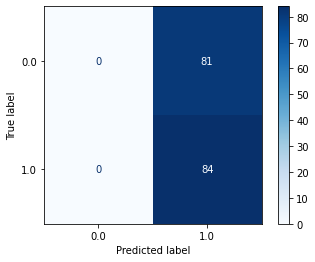

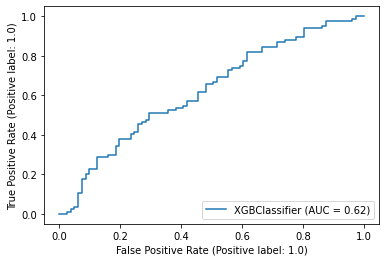

In [ ]:
xgb_best_pg_topic, xgb_f1_best_pg_topic, xgb_auc_best_pg_topic = xgboost_clf_optim(xgb_optimised_topic_pg, pg_train, pg_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI',  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'movement')

In [ ]:
pd.DataFrame([[xgb_f1_best_pg, xgb_auc_best_pg],[xgb_f1_best_pg_sent, xgb_auc_best_pg_sent],[xgb_f1_best_pg_topic, xgb_auc_best_pg_topic]], columns = ['F1', 'AUC'], index = ['Best', '+Sentiment', '+Topic'])

,F1,AUC
Best,0.674699,0.593401
+Sentiment,0.674699,0.570694
+Topic,0.674699,0.622575


CNN

Epoch 1/30
905/905 [==============================] - 27s 29ms/step - loss: 0.7010 - auc_1: 0.4964 - val_loss: 0.6926 - val_auc_1: 0.5111
Epoch 2/30
905/905 [==============================] - 24s 27ms/step - loss: 0.6917 - auc_1: 0.4842 - val_loss: 0.6930 - val_auc_1: 0.5000
Epoch 3/30
905/905 [==============================] - 24s 27ms/step - loss: 0.6906 - auc_1: 0.4770 - val_loss: 0.6940 - val_auc_1: 0.4976
Epoch 4/30
905/905 [==============================] - 24s 27ms/step - loss: 0.6932 - auc_1: 0.4793 - val_loss: 0.6944 - val_auc_1: 0.4975
Epoch 5/30
905/905 [==============================] - 24s 27ms/step - loss: 0.6911 - auc_1: 0.4648 - val_loss: 0.6924 - val_auc_1: 0.4943
Epoch 6/30
905/905 [==============================] - 24s 27ms/step - loss: 0.6904 - auc_1: 0.4858 - val_loss: 0.6921 - val_auc_1: 0.5013
Epoch 7/30
905/905 [==============================] - 25s 27ms/step - loss: 0.6875 - auc_1: 0.4813 - val_loss: 0.6922 - val_auc_1: 0.5010
Epoch 8/30
905/905 [==============

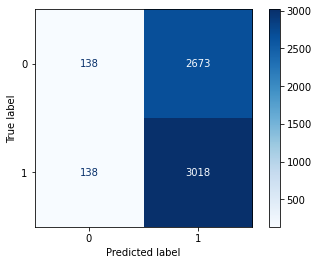

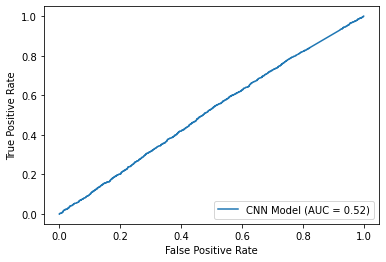

In [ ]:
model_base, cnn_f1, cnn_auc = cnn_clf(df_aapl, df_price_aapl, ['Text', 'SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement', 30)

Epoch 1/30
905/905 [==============================] - 27s 28ms/step - loss: 0.7009 - auc_2: 0.4943 - val_loss: 0.6929 - val_auc_2: 0.4998
Epoch 2/30
905/905 [==============================] - 24s 26ms/step - loss: 0.6926 - auc_2: 0.4846 - val_loss: 0.6927 - val_auc_2: 0.5047
Epoch 3/30
905/905 [==============================] - 24s 26ms/step - loss: 0.6911 - auc_2: 0.4837 - val_loss: 0.6931 - val_auc_2: 0.5001
Epoch 4/30
905/905 [==============================] - 24s 26ms/step - loss: 0.6943 - auc_2: 0.4818 - val_loss: 0.6930 - val_auc_2: 0.4981
Epoch 5/30
905/905 [==============================] - 24s 26ms/step - loss: 0.6928 - auc_2: 0.4844 - val_loss: 0.6929 - val_auc_2: 0.4990
Epoch 6/30
905/905 [==============================] - 24s 26ms/step - loss: 0.6926 - auc_2: 0.4890 - val_loss: 0.6922 - val_auc_2: 0.5002
Epoch 7/30
905/905 [==============================] - 24s 26ms/step - loss: 0.6908 - auc_2: 0.4951 - val_loss: 0.6922 - val_auc_2: 0.4960
Epoch 8/30
905/905 [==============

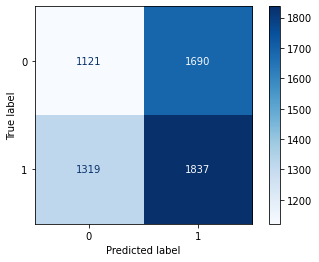

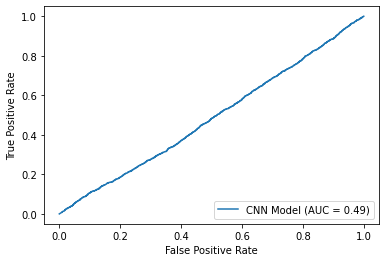

In [ ]:
model_trend, cnn_f1_trend, cnn_auc_trend = cnn_clf(df_aapl, df_price_aapl, ['Text', 'SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'Apple'], 'movement', 30)

In [ ]:
pd.DataFrame([[cnn_f1, cnn_auc],[cnn_f1_trend, cnn_auc_trend]], columns = ['F1', 'AUC'], index = ['CNN', '+Trend'])

,F1,AUC
CNN,0.682265,0.516216
+Trend,0.549753,0.486010
